Clean   

This notebook requires loading mpd_track_map.csv and combined_feats_df.csv. We standardize track audio features before computing standard deviations of each feature by playlist as a measure of within-playlist diversity. We also visualize audio feature contribution to diversity by feature. Finally, we produce a scaled diversity score between 0 and 1 for each playlist.

In [55]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import hdbscan

In [56]:
mpd = pd.read_csv("mpd_track_map.csv")
audio_features = pd.read_csv("combined_feats_df.csv")

In [57]:
# cleaning genre col
audio_features["genre"] = audio_features["genre"].apply(lambda x: x.lower())

In [58]:
audio_features.head(2)

,artist_name,track_name,track_id,popularity,genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,acoustic,0.483,0.303,-10.058,0.0429,0.694,0.000000,0.1150,0.139,133.406,240166
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,acoustic,0.572,0.454,-10.286,0.0258,0.477,0.000014,0.0974,0.515,140.182,216387


Standardized Audio Features Before Calculating Within-Playlist Diversity

In [59]:
# standardization
meta_cols = ["track_id", "track_name", "artist_name", "genre", "popularity", "tempo", "duration_ms"]
feature_cols = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(audio_features[feature_cols])

scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
scaled_df["track_id"] = audio_features["track_id"]
scaled_df["genre"] = audio_features["genre"]
scaled_df.head(2)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_id,genre
0,-0.293685,-1.196852,-0.157397,-0.388889,1.010792,-0.677952,-0.535177,-1.175156,53QF56cjZA9RTuuMZDrSA6,acoustic
1,0.186134,-0.643510,-0.196813,-0.513112,0.404216,-0.677914,-0.622190,0.222201,1s8tP3jP4GZcyHDsjvw218,acoustic


In [60]:
# standardized feature values for each track in each playlist
merged_df = mpd.merge(scaled_df, on="track_id", how="inner")
merged_df.head(2)

,playlist_id,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,genre
0,0,0UaMYEvWZi0ZqiDOoHU3YI,1.976023,0.672051,0.353109,0.178466,-0.842199,-0.658733,-0.870869,1.318532,dance
1,0,6I9VzXrHxO9rA9A5euc8Ak,1.275163,0.763664,0.904760,0.127614,-0.859529,-0.609016,0.092700,1.742199,dance


In [61]:
# filter out playlists with fewer than 10 tracks
playlist_sizes = merged_df.groupby("playlist_id").size()
valid_playlists = playlist_sizes[playlist_sizes >= 10].index
merged_df = merged_df[merged_df["playlist_id"].isin(valid_playlists)]
merged_df.head(2)

,playlist_id,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,genre
0,0,0UaMYEvWZi0ZqiDOoHU3YI,1.976023,0.672051,0.353109,0.178466,-0.842199,-0.658733,-0.870869,1.318532,dance
1,0,6I9VzXrHxO9rA9A5euc8Ak,1.275163,0.763664,0.904760,0.127614,-0.859529,-0.609016,0.092700,1.742199,dance


In [62]:
# Group by playlist_id and compute SD per feature
playlist_feature_sd = merged_df.groupby("playlist_id")[feature_cols].std()

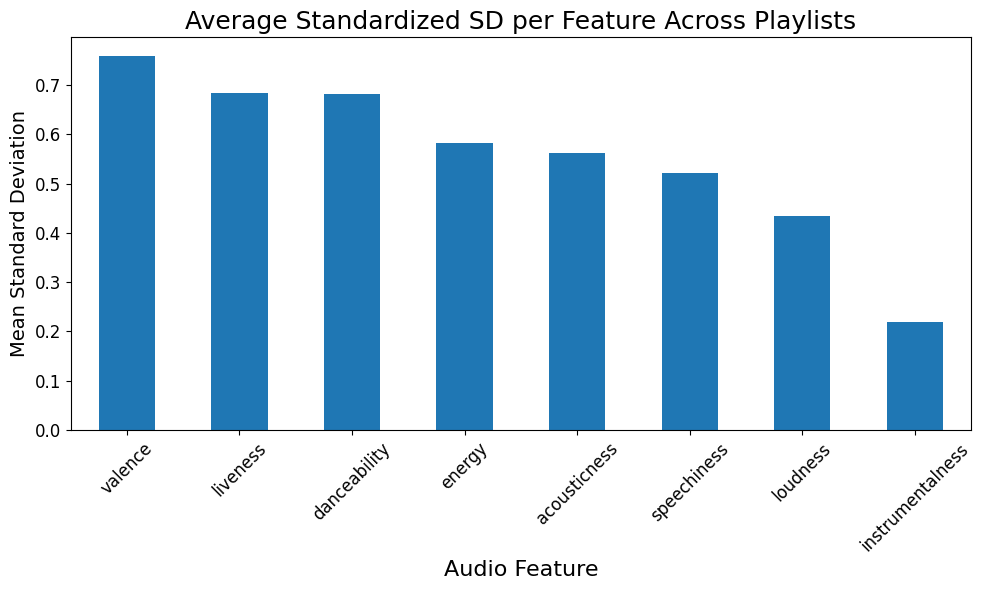

In [63]:
# which audio features vary the most within playlists, i.e. diversity contributions by feature
feature_diversity = playlist_feature_sd.mean().sort_values(ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_diversity.plot(kind="bar")
plt.title("Average Standardized SD per Feature Across Playlists", fontsize=18)
plt.ylabel("Mean Standard Deviation", fontsize=14)
plt.xlabel("Audio Feature", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# computing diversity scores for each playlist where mean SD across all features = diversity score
playlist_feature_sd['diversity_score'] = playlist_feature_sd.mean(axis=1)

In [12]:
# standardizing diversity scores (between 0 and 1)
scaler = MinMaxScaler()
playlist_feature_sd['diversity_score_scaled'] = scaler.fit_transform(
    playlist_feature_sd[['diversity_score']]
)

In [13]:
# df of playlists with audio feature sd's and scaled within-playlist diversity score
playlist_feature_sd = playlist_feature_sd.reset_index().rename(columns={"index": "playlist_id"})
playlist_feature_sd.head(5)

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,diversity_score,diversity_score_scaled
0,0,0.816158,0.538485,0.254430,0.740683,0.404926,0.013129,0.850835,0.748315,0.545870,0.415634
1,1,0.601288,0.690305,0.340408,1.008941,0.545757,0.509599,0.751342,0.777782,0.653178,0.497340
2,2,0.556185,0.660666,0.349388,0.566637,0.691453,0.017855,0.534629,0.757204,0.516752,0.393463
3,3,0.922418,0.915293,0.882509,0.426098,0.966007,1.003456,0.458668,0.912016,0.810808,0.617363
4,5,0.672788,0.537471,0.352364,0.355319,0.447404,0.010718,0.637996,0.815903,0.478746,0.364525


Analysis 2

In [14]:
# this dataframe contains playlist ids, track ids, audio features (scaled), and diversity scores (scaled)
merged_diversity = merged_df.merge(playlist_feature_sd[["playlist_id", "diversity_score", "diversity_score_scaled"]],
                                        on="playlist_id", how="inner")
merged_diversity.head()

,playlist_id,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,genre,diversity_score,diversity_score_scaled
0,0,0UaMYEvWZi0ZqiDOoHU3YI,1.976023,0.672051,0.353109,0.178466,-0.842199,-0.658733,-0.870869,1.318532,dance,0.54587,0.415634
1,0,6I9VzXrHxO9rA9A5euc8Ak,1.275163,0.763664,0.904760,0.127614,-0.859529,-0.609016,0.092700,1.742199,dance,0.54587,0.415634
2,0,1AWQoqb9bSvzTjaLralEkT,1.911328,0.309264,0.534630,0.323755,-0.367281,-0.677306,-0.846149,1.344546,dance,0.54587,0.415634
3,0,68vgtRHr7iZHpzGpon6Jlo,0.671345,-0.449291,0.157239,0.156672,-0.210745,-0.677952,-0.873835,0.820537,dance,0.54587,0.415634
4,0,3BxWKCI06eQ5Od8TY2JBeA,0.175352,0.701367,0.824199,1.239078,-0.431572,-0.677952,0.325064,-0.175451,dance,0.54587,0.415634


In [15]:
# Playlist vectors
playlist_vectors = merged_diversity.groupby("playlist_id")[feature_cols].mean().reset_index()
playlist_vectors.head()

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760


In [16]:
# add track count column
playlist_counts = mpd.groupby("playlist_id").count().reset_index()
playlist_counts = playlist_counts.rename(columns={"track_id": "track_count"})

playlist_vectors = playlist_vectors.merge(playlist_counts, on="playlist_id")
playlist_vectors = playlist_vectors[playlist_vectors["track_count"] >= 10]
playlist_vectors

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_count
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233,52
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147,39
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954,64
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328,126
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760,80
...,...,...,...,...,...,...,...,...,...,...
785764,999993,0.158100,0.715292,0.875670,-0.221516,-0.716332,-0.653011,-0.185807,0.463765,27
785765,999994,0.537026,-0.235807,0.314355,0.217362,-0.271878,-0.677442,-0.346263,-0.035716,65
785766,999995,-0.182958,0.085587,0.479189,-0.414147,-0.409654,-0.676564,-0.480680,-0.330210,32
785767,999996,-0.369709,0.413994,0.555220,-0.357094,-0.701316,-0.653215,-0.068629,-0.388561,122


PCA

In [17]:
# Drop metadata columns, keep only audio features
X = playlist_vectors[feature_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Run PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add back to DataFrame for plotting later
playlist_vectors_pca = playlist_vectors.copy()
playlist_vectors_pca["PC1"] = X_pca[:, 0]
playlist_vectors_pca["PC2"] = X_pca[:, 1]


In [19]:
playlist_vectors_pca

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_count,PC1,PC2
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233,52,1.990707,-0.437731
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147,39,-0.438979,-0.611606
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954,64,1.075485,-0.153831
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328,126,-2.473399,-0.535082
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760,80,1.547046,-0.399077
...,...,...,...,...,...,...,...,...,...,...,...,...
785764,999993,0.158100,0.715292,0.875670,-0.221516,-0.716332,-0.653011,-0.185807,0.463765,27,1.763411,-1.581080
785765,999994,0.537026,-0.235807,0.314355,0.217362,-0.271878,-0.677442,-0.346263,-0.035716,65,-0.316536,0.857281
785766,999995,-0.182958,0.085587,0.479189,-0.414147,-0.409654,-0.676564,-0.480680,-0.330210,32,-0.658577,-1.205644
785767,999996,-0.369709,0.413994,0.555220,-0.357094,-0.701316,-0.653215,-0.068629,-0.388561,122,0.227199,-1.721980


Kmeans

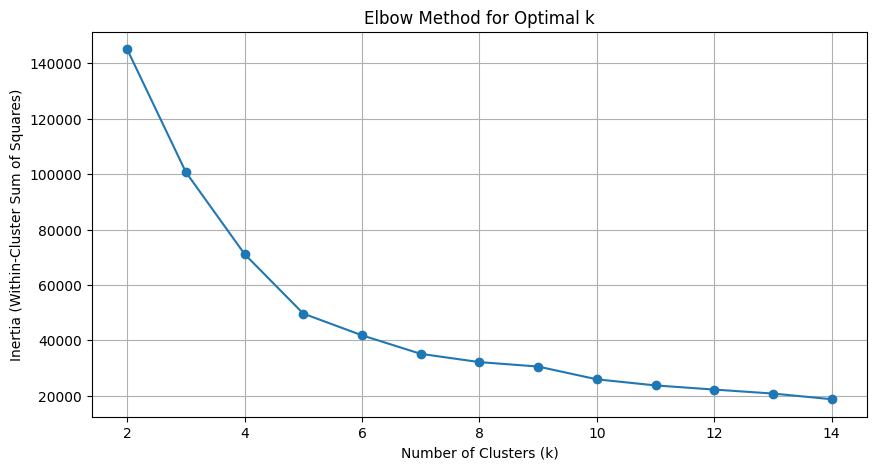

In [20]:
# Use only the pca features
X = playlist_vectors_pca[["PC1", "PC2"]]

X_sampled = X.sample(n=50000, random_state=42) 

inertia = []
k_values = range(2, 15)

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    labels = kmeans.fit_predict(X_sampled)
    inertia.append(kmeans.inertia_)


# Plot elbow curve (inertia)
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [21]:
# Hyperparameter-tuned clustering
X = playlist_vectors_pca[["PC1", "PC2"]]
kmeans = KMeans(n_clusters=6, random_state=42)
playlist_vectors_pca["cluster_pca"] = kmeans.fit_predict(X)
playlist_vectors_pca.head()

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_count,PC1,PC2,cluster_pca
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233,52,1.990707,-0.437731,4
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147,39,-0.438979,-0.611606,3
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954,64,1.075485,-0.153831,4
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328,126,-2.473399,-0.535082,1
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760,80,1.547046,-0.399077,4


In [22]:
meta_cols = ["track_id", "genre", "popularity", "tempo", "duration_ms"]


audio_features.head() # tralck, popularity, genre, tempo, duration
merged_diversity.head() # track, diversity scores
meta_df = merged_diversity.merge(audio_features[meta_cols], on="track_id", how="left")
meta_df.head()

,playlist_id,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,genre_x,diversity_score,diversity_score_scaled,genre_y,popularity,tempo,duration_ms
0,0,0UaMYEvWZi0ZqiDOoHU3YI,1.976023,0.672051,0.353109,0.178466,-0.842199,-0.658733,-0.870869,1.318532,dance,0.54587,0.415634,dance,66,125.461,226864
1,0,6I9VzXrHxO9rA9A5euc8Ak,1.275163,0.763664,0.904760,0.127614,-0.859529,-0.609016,0.092700,1.742199,dance,0.54587,0.415634,dance,79,143.040,198800
2,0,1AWQoqb9bSvzTjaLralEkT,1.911328,0.309264,0.534630,0.323755,-0.367281,-0.677306,-0.846149,1.344546,dance,0.54587,0.415634,dance,75,100.972,267267
3,0,68vgtRHr7iZHpzGpon6Jlo,0.671345,-0.449291,0.157239,0.156672,-0.210745,-0.677952,-0.873835,0.820537,dance,0.54587,0.415634,dance,76,86.412,223440
4,0,3BxWKCI06eQ5Od8TY2JBeA,0.175352,0.701367,0.824199,1.239078,-0.431572,-0.677952,0.325064,-0.175451,dance,0.54587,0.415634,dance,64,210.857,225560


In [23]:
meta_df.shape

(32073323, 17)

In [24]:
# Step 1: Ensure playlist_metadata and diversity data are loaded and merged properly
# Assumes you have a dataframe with per-playlist values for the following:
# - playlist_id
# - diversity_score
# - diversity_score_scaled
# - genre (or top_genre)
# - popularity (mean or median per playlist)
# - tempo (mean per playlist)
# - duration_ms (mean per playlist)

# If not already computed, here’s how you might compute or extract them:

# For example, if track_df has one row per track and includes playlist_id and track-level metadata:
# 'track_df' should have columns: playlist_id, track_id, genre, popularity, tempo, duration_ms, etc.

# First, get per-playlist aggregates
meta_agg_df = meta_df.groupby("playlist_id").agg({
    "diversity_score": "mean",
    "diversity_score_scaled": "mean",
    "popularity": "mean",
    "tempo": "mean",
    "duration_ms": "mean",
    "genre_x": lambda x: x.value_counts().head(1).index[0]
}).rename(columns={"genre_x": "top_genre"}).reset_index()

meta_agg_df


,playlist_id,diversity_score,diversity_score_scaled,popularity,tempo,duration_ms,top_genre
0,0,0.545870,0.415634,69.172414,124.944931,224506.206897,dance
1,1,0.653178,0.497340,68.052632,123.066579,329408.421053,rock
2,2,0.516752,0.393463,55.459459,116.629919,218547.459459,k-pop
3,3,0.810808,0.617363,51.268293,124.245756,243825.658537,indie
4,5,0.478746,0.364525,67.783784,117.477081,234804.027027,dance
...,...,...,...,...,...,...,...
785764,999993,0.411238,0.313123,68.000000,122.440533,206383.933333,dance
785765,999994,0.501088,0.381537,57.771429,119.713486,253603.514286,dance
785766,999995,0.423959,0.322809,43.153846,123.783115,264613.307692,alt-rock
785767,999996,0.529196,0.402938,42.043478,130.310275,275888.681159,alt-rock


In [25]:
all_df = pd.merge(playlist_vectors_pca, meta_agg_df, on='playlist_id', how='left')
all_df

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_count,PC1,PC2,cluster_pca,diversity_score,diversity_score_scaled,popularity,tempo,duration_ms,top_genre
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233,52,1.990707,-0.437731,4,0.545870,0.415634,69.172414,124.944931,224506.206897,dance
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147,39,-0.438979,-0.611606,3,0.653178,0.497340,68.052632,123.066579,329408.421053,rock
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954,64,1.075485,-0.153831,4,0.516752,0.393463,55.459459,116.629919,218547.459459,k-pop
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328,126,-2.473399,-0.535082,1,0.810808,0.617363,51.268293,124.245756,243825.658537,indie
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760,80,1.547046,-0.399077,4,0.478746,0.364525,67.783784,117.477081,234804.027027,dance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785764,999993,0.158100,0.715292,0.875670,-0.221516,-0.716332,-0.653011,-0.185807,0.463765,27,1.763411,-1.581080,0,0.411238,0.313123,68.000000,122.440533,206383.933333,dance
785765,999994,0.537026,-0.235807,0.314355,0.217362,-0.271878,-0.677442,-0.346263,-0.035716,65,-0.316536,0.857281,3,0.501088,0.381537,57.771429,119.713486,253603.514286,dance
785766,999995,-0.182958,0.085587,0.479189,-0.414147,-0.409654,-0.676564,-0.480680,-0.330210,32,-0.658577,-1.205644,3,0.423959,0.322809,43.153846,123.783115,264613.307692,alt-rock
785767,999996,-0.369709,0.413994,0.555220,-0.357094,-0.701316,-0.653215,-0.068629,-0.388561,122,0.227199,-1.721980,0,0.529196,0.402938,42.043478,130.310275,275888.681159,alt-rock


In [26]:

# Identify the most influential audio feature per cluster based on PCA loadings ---

# Get the absolute value of the PCA component matrix (e.g., from pca.components_)
pca_components_df = pd.DataFrame(pca.components_, columns=feature_cols, index=[f"PC{i+1}" for i in range(pca.n_components_)])
top_features = pca_components_df.abs().idxmax(axis=1)  # Most contributing feature per PC

# Optionally: get the top contributing feature to PC1 per cluster
# You can replace this logic if you're using a different method to identify influence

# --- Step 3: Group and summarize by cluster ---
summary = all_df.groupby("cluster_pca").agg({
    "top_genre": lambda x: x.value_counts().head(1).index[0],
    "track_count": "mean",
    "diversity_score_scaled": "mean",
    "popularity": "mean",
    "tempo": "mean",
    "duration_ms": "mean"
}).reset_index()

# Rename columns for clarity
summary.columns = [
    "cluster", "top_genre", "avg_track_count", "avg_diversity_scaled",
    "avg_popularity", "avg_tempo", "avg_duration_ms"
]

summary

,cluster,top_genre,avg_track_count,avg_diversity_scaled,avg_popularity,avg_tempo,avg_duration_ms
0,0,dance,82.264226,0.383473,57.552584,124.994436,233404.880550
1,1,folk,71.417475,0.475689,51.698360,117.155811,237740.158513
2,2,hip-hop,77.036321,0.428985,61.890203,121.483098,233638.441151
3,3,folk,77.274402,0.451671,56.250636,119.676291,244846.442963
4,4,dance,78.810249,0.410050,61.399864,120.594421,231864.991637
5,5,soundtrack,84.183982,0.449196,39.963629,106.035745,255649.432557


In [27]:
# Assuming `X_scaled` was the standardized playlist vectors input to PCA
# Get the original column names from your playlist vector features (before PCA)

# Build the PCA loadings matrix
loadings = pd.DataFrame(
    pca.components_, 
    columns=feature_cols,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# View transposed so features are rows
loadings.T

,PC1,PC2
danceability,0.321387,0.550489
energy,0.451979,-0.368766
loudness,0.479364,-0.157527
speechiness,0.206854,0.697189
acousticness,-0.464782,0.147691
instrumentalness,-0.321077,-0.093190
liveness,0.154989,-0.010072
valence,0.276970,-0.139600


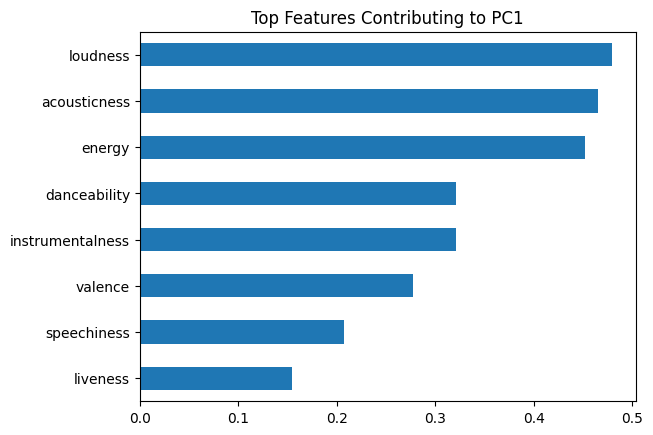

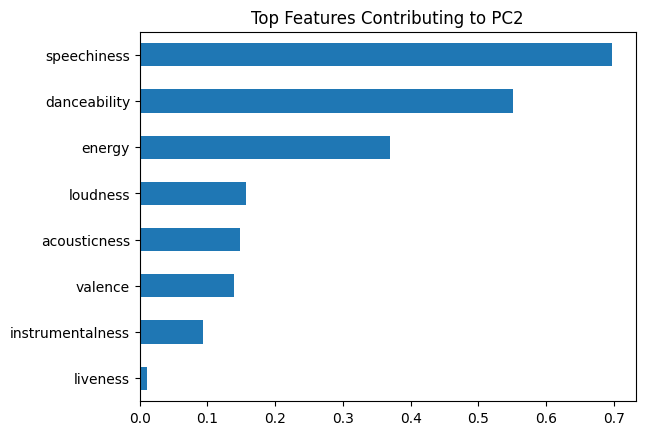

In [28]:
# Plot top features contributing to PC1
abs_pc1 = loadings.loc["PC1"].abs().sort_values(ascending=False)
abs_pc1.head(10).plot(kind="barh", title="Top Features Contributing to PC1")
plt.gca().invert_yaxis()
plt.show()

# Plot top features contributing to PC2
abs_pc2 = loadings.loc["PC2"].abs().sort_values(ascending=False)
abs_pc2.head(10).plot(kind="barh", title="Top Features Contributing to PC2")
plt.gca().invert_yaxis()
plt.show()


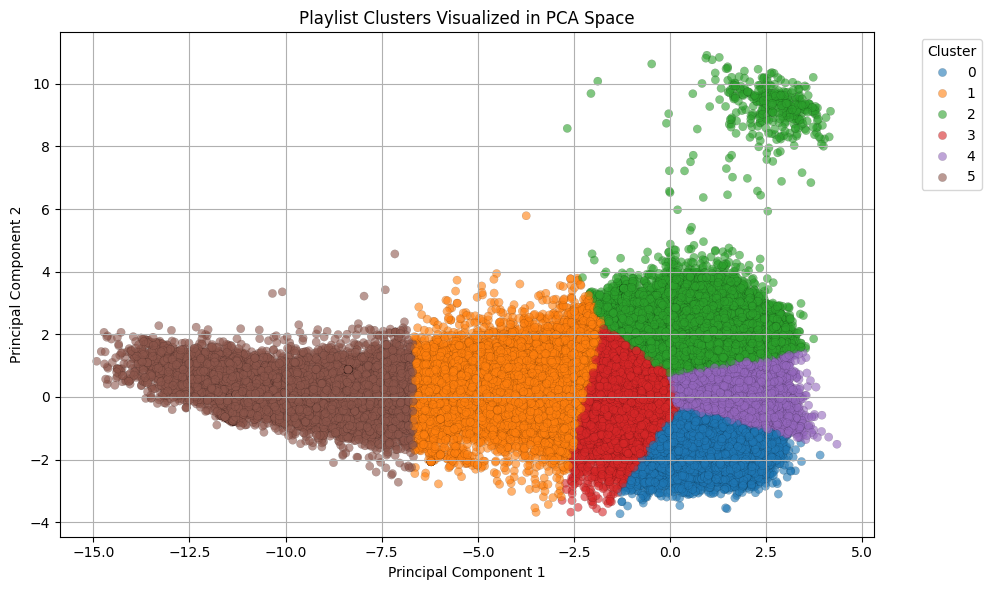

In [29]:
# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_df,
    x="PC1",
    y="PC2",
    hue="cluster_pca",
    palette="tab10",
    alpha=0.6,
    edgecolor="black",
    linewidth=0.1
)
plt.title("Playlist Clusters Visualized in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.neighbors import NearestNeighbors

# Select PCA components
X_pca = all_df[["PC1", "PC2"]].values

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=30)
labels = clusterer.fit_predict(X_pca)

# Identify noise points
noise_mask = labels == -1
core_points = X[~noise_mask]
core_labels = labels[~noise_mask]

# Use Nearest Neighbors to assign labels to noise
nn = NearestNeighbors(n_neighbors=1).fit(core_points)
_, idx = nn.kneighbors(X[noise_mask])
labels[noise_mask] = core_labels[idx.flatten()]

# Attach labels to DataFrame
all_df["hdbscan_cluster"] = labels


c:\Users\norma\anaconda3\envs\ex9\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\norma\anaconda3\envs\ex9\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [31]:
all_df.head()

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_count,PC1,PC2,cluster_pca,diversity_score,diversity_score_scaled,popularity,tempo,duration_ms,top_genre,hdbscan_cluster
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233,52,1.990707,-0.437731,4,0.545870,0.415634,69.172414,124.944931,224506.206897,dance,2
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147,39,-0.438979,-0.611606,3,0.653178,0.497340,68.052632,123.066579,329408.421053,rock,2
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954,64,1.075485,-0.153831,4,0.516752,0.393463,55.459459,116.629919,218547.459459,k-pop,2
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328,126,-2.473399,-0.535082,1,0.810808,0.617363,51.268293,124.245756,243825.658537,indie,2
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760,80,1.547046,-0.399077,4,0.478746,0.364525,67.783784,117.477081,234804.027027,dance,2


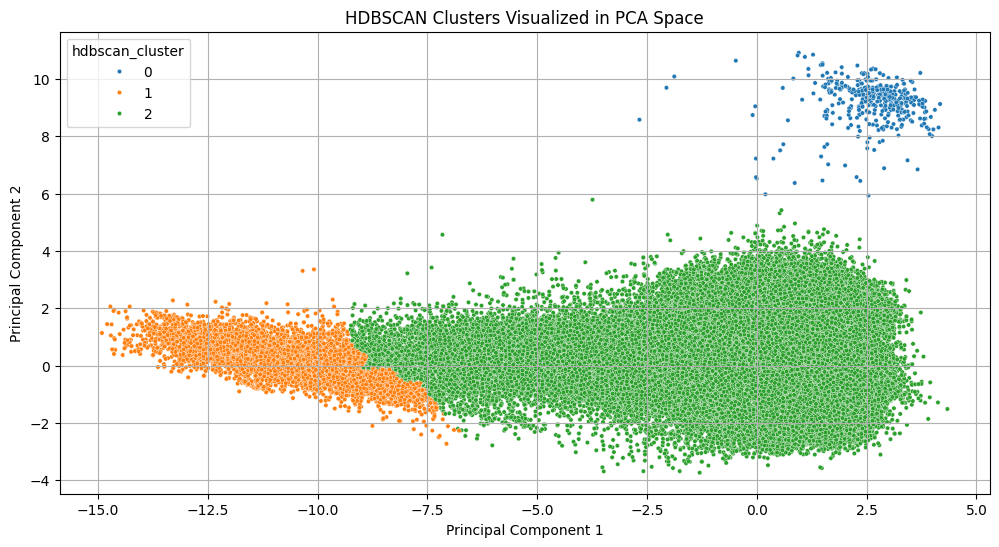

In [32]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=all_df,
    x="PC1",
    y="PC2",
    hue="hdbscan_cluster",
    palette="tab10",
    legend="full",
    s=10
)
plt.title("HDBSCAN Clusters Visualized in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [33]:
summary_h = all_df.groupby("hdbscan_cluster").agg({
    "top_genre": lambda x: x.value_counts().head(1).index[0],
    "track_count": "mean",
    "diversity_score_scaled": "mean",
    "popularity": "mean",
    "tempo": "mean",
    "duration_ms": "mean"
}).reset_index()

# Rename columns for clarity
summary_h.columns = [
    "cluster", "top_genre", "avg_track_count", "avg_diversity_scaled",
    "avg_popularity", "avg_tempo", "avg_duration_ms"
]

summary_h

,cluster,top_genre,avg_track_count,avg_diversity_scaled,avg_popularity,avg_tempo,avg_duration_ms
0,0,comedy,107.477212,0.396137,33.010102,98.110395,262906.240992
1,1,soundtrack,84.569733,0.420048,39.007067,104.178170,259437.926960
2,2,hip-hop,78.333949,0.423241,58.350175,121.360364,236344.680265


Analysis 3

In [34]:
# Next, we see if genre makeup corresponds with diversity scores post clustering


In [35]:
merged_diversity

,playlist_id,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,genre,diversity_score,diversity_score_scaled
0,0,0UaMYEvWZi0ZqiDOoHU3YI,1.976023,0.672051,0.353109,0.178466,-0.842199,-0.658733,-0.870869,1.318532,dance,0.545870,0.415634
1,0,6I9VzXrHxO9rA9A5euc8Ak,1.275163,0.763664,0.904760,0.127614,-0.859529,-0.609016,0.092700,1.742199,dance,0.545870,0.415634
2,0,1AWQoqb9bSvzTjaLralEkT,1.911328,0.309264,0.534630,0.323755,-0.367281,-0.677306,-0.846149,1.344546,dance,0.545870,0.415634
3,0,68vgtRHr7iZHpzGpon6Jlo,0.671345,-0.449291,0.157239,0.156672,-0.210745,-0.677952,-0.873835,0.820537,dance,0.545870,0.415634
4,0,3BxWKCI06eQ5Od8TY2JBeA,0.175352,0.701367,0.824199,1.239078,-0.431572,-0.677952,0.325064,-0.175451,dance,0.545870,0.415634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32073318,999997,3083fDw5aGcjzB5FMauzrH,-0.331424,0.323922,0.300900,-0.189116,-0.425982,-0.677952,-0.760619,0.530660,dance,0.558124,0.424964
32073319,999997,2HtB8ufBuodeUcNWhTNsS1,0.876212,-0.533575,0.412406,-0.401965,-0.772037,-0.677715,-0.613291,-0.621416,hip-hop,0.558124,0.424964
32073320,999997,2i8hWheuwDUwyPrZynCLEF,1.431509,0.587767,0.828867,0.207524,-0.905009,-0.677952,-0.885700,0.954327,dance,0.558124,0.424964
32073321,999997,4NYwy0R3NdvORX2B6OZXBT,1.054122,-0.812078,0.227082,-0.418673,0.968863,-0.677844,-0.559897,-0.610267,hip-hop,0.558124,0.424964


In [36]:
# Count how many unique genres appear in each playlist
genre_counts = merged_diversity.groupby("playlist_id")["genre"].nunique().reset_index()
genre_counts.columns = ["playlist_id", "num_unique_genres"]

In [37]:
playlist_meta = merged_diversity.merge(
    genre_counts, on="playlist_id", how="left"
)

In [38]:
playlist_meta

,playlist_id,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,genre,diversity_score,diversity_score_scaled,num_unique_genres
0,0,0UaMYEvWZi0ZqiDOoHU3YI,1.976023,0.672051,0.353109,0.178466,-0.842199,-0.658733,-0.870869,1.318532,dance,0.545870,0.415634,4
1,0,6I9VzXrHxO9rA9A5euc8Ak,1.275163,0.763664,0.904760,0.127614,-0.859529,-0.609016,0.092700,1.742199,dance,0.545870,0.415634,4
2,0,1AWQoqb9bSvzTjaLralEkT,1.911328,0.309264,0.534630,0.323755,-0.367281,-0.677306,-0.846149,1.344546,dance,0.545870,0.415634,4
3,0,68vgtRHr7iZHpzGpon6Jlo,0.671345,-0.449291,0.157239,0.156672,-0.210745,-0.677952,-0.873835,0.820537,dance,0.545870,0.415634,4
4,0,3BxWKCI06eQ5Od8TY2JBeA,0.175352,0.701367,0.824199,1.239078,-0.431572,-0.677952,0.325064,-0.175451,dance,0.545870,0.415634,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32073318,999997,3083fDw5aGcjzB5FMauzrH,-0.331424,0.323922,0.300900,-0.189116,-0.425982,-0.677952,-0.760619,0.530660,dance,0.558124,0.424964,4
32073319,999997,2HtB8ufBuodeUcNWhTNsS1,0.876212,-0.533575,0.412406,-0.401965,-0.772037,-0.677715,-0.613291,-0.621416,hip-hop,0.558124,0.424964,4
32073320,999997,2i8hWheuwDUwyPrZynCLEF,1.431509,0.587767,0.828867,0.207524,-0.905009,-0.677952,-0.885700,0.954327,dance,0.558124,0.424964,4
32073321,999997,4NYwy0R3NdvORX2B6OZXBT,1.054122,-0.812078,0.227082,-0.418673,0.968863,-0.677844,-0.559897,-0.610267,hip-hop,0.558124,0.424964,4


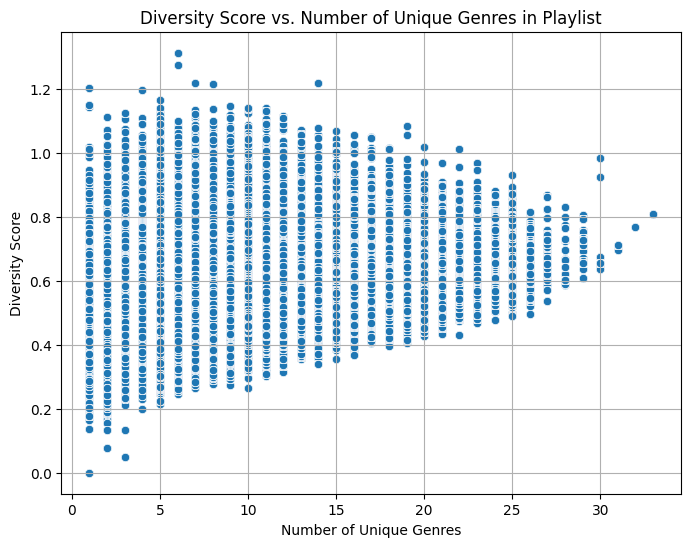

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=playlist_meta,
    x="num_unique_genres",
    y="diversity_score"
)
plt.title("Diversity Score vs. Number of Unique Genres in Playlist")
plt.xlabel("Number of Unique Genres")
plt.ylabel("Diversity Score")
plt.grid(True)

plt.show()

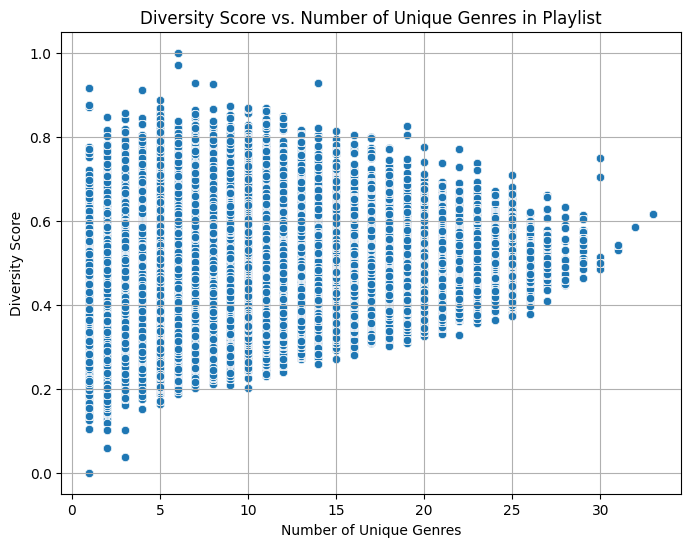

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=playlist_meta,
    x="num_unique_genres",
    y="diversity_score_scaled"
)
plt.title("Diversity Score vs. Number of Unique Genres in Playlist")
plt.xlabel("Number of Unique Genres")
plt.ylabel("Diversity Score")
plt.grid(True)
plt.show()


In [41]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(playlist_meta["num_unique_genres"], playlist_meta["diversity_score"])
spearman_corr, _ = spearmanr(playlist_meta["num_unique_genres"], playlist_meta["diversity_score"])

print(f"Pearson r = {pearson_corr:.3f}")
print(f"Spearman ρ = {spearman_corr:.3f}")


Pearson r = 0.366
Spearman ρ = 0.370


In [42]:
all_df

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,track_count,PC1,PC2,cluster_pca,diversity_score,diversity_score_scaled,popularity,tempo,duration_ms,top_genre,hdbscan_cluster
0,0,0.589175,0.534189,0.762845,0.123156,-0.611830,-0.674645,-0.186938,0.813233,52,1.990707,-0.437731,4,0.545870,0.415634,69.172414,124.944931,224506.206897,dance,2
1,1,-0.157202,0.141853,0.061684,0.024306,-0.501985,-0.539133,-0.271276,0.260147,39,-0.438979,-0.611606,3,0.653178,0.497340,68.052632,123.066579,329408.421053,rock,2
2,2,0.642058,0.319663,0.758337,0.014269,-0.267551,-0.674972,-0.334828,0.483954,64,1.075485,-0.153831,4,0.516752,0.393463,55.459459,116.629919,218547.459459,k-pop,2
3,3,-0.086846,-0.169438,-0.142167,-0.244007,-0.019507,0.035734,-0.324663,-0.087328,126,-2.473399,-0.535082,1,0.810808,0.617363,51.268293,124.245756,243825.658537,indie,2
4,5,0.857124,0.375423,0.648593,-0.199463,-0.655012,-0.674778,-0.153413,0.439760,80,1.547046,-0.399077,4,0.478746,0.364525,67.783784,117.477081,234804.027027,dance,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785764,999993,0.158100,0.715292,0.875670,-0.221516,-0.716332,-0.653011,-0.185807,0.463765,27,1.763411,-1.581080,0,0.411238,0.313123,68.000000,122.440533,206383.933333,dance,2
785765,999994,0.537026,-0.235807,0.314355,0.217362,-0.271878,-0.677442,-0.346263,-0.035716,65,-0.316536,0.857281,3,0.501088,0.381537,57.771429,119.713486,253603.514286,dance,2
785766,999995,-0.182958,0.085587,0.479189,-0.414147,-0.409654,-0.676564,-0.480680,-0.330210,32,-0.658577,-1.205644,3,0.423959,0.322809,43.153846,123.783115,264613.307692,alt-rock,2
785767,999996,-0.369709,0.413994,0.555220,-0.357094,-0.701316,-0.653215,-0.068629,-0.388561,122,0.227199,-1.721980,0,0.529196,0.402938,42.043478,130.310275,275888.681159,alt-rock,2


In [ ]:
corr = df[['diversity_score', 'followers', 'avg_track_popularity', 'num_tracks']].corr()
sns.heatmap(corr, annot=True, cmap='vlag')


Text(0.5, 1.0, 'Playlist Size vs. Diversity')

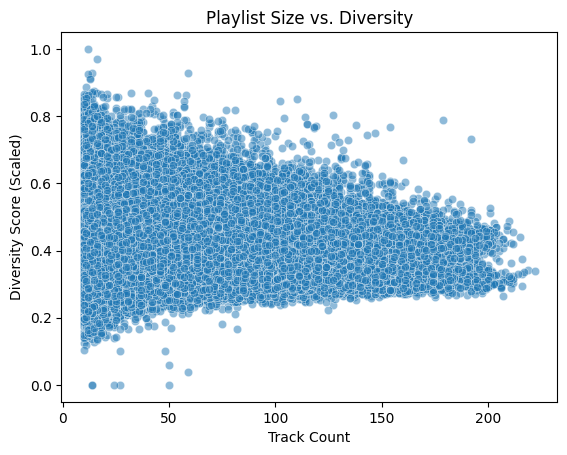

In [44]:
playlist_sizes = merged_df.groupby("playlist_id").size().rename("track_count")
div_data = playlist_feature_sd.merge(playlist_sizes, on="playlist_id")

sns.scatterplot(data=div_data, x="track_count", y="diversity_score_scaled", alpha=0.5)
plt.xlabel("Track Count")
plt.ylabel("Diversity Score (Scaled)")
plt.title("Playlist Size vs. Diversity")


Text(0, 0.5, 'Mean Std Dev')

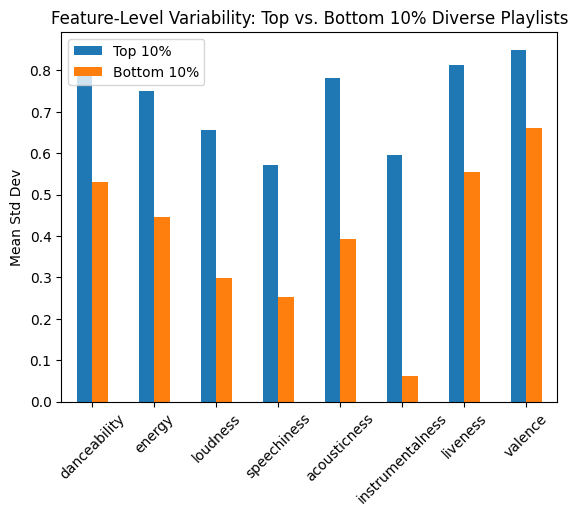

In [48]:
top10 = playlist_feature_sd.nlargest(int(len(playlist_feature_sd)*0.1), "diversity_score_scaled")
bottom10 = playlist_feature_sd.nsmallest(int(len(playlist_feature_sd)*0.1), "diversity_score_scaled")

mean_features_top = top10[feature_cols].mean()
mean_features_bottom = bottom10[feature_cols].mean()

pd.DataFrame({"Top 10%": mean_features_top, "Bottom 10%": mean_features_bottom}).plot.bar()
plt.title("Feature-Level Variability: Top vs. Bottom 10% Diverse Playlists")
plt.xticks(rotation=45)
plt.ylabel("Mean Std Dev")

Text(0.5, 1.0, 'Correlation Matrix (Audio Features & Diversity)')

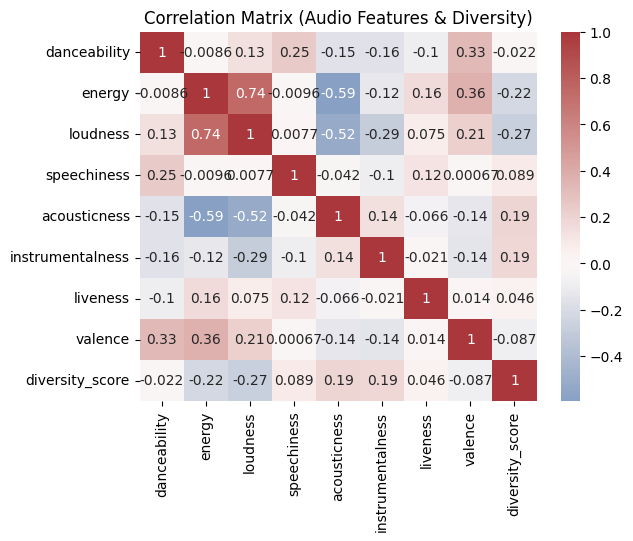

In [46]:
subset = merged_diversity[feature_cols + ["diversity_score"]]
sns.heatmap(subset.corr(), annot=True, cmap="vlag", center=0)
plt.title("Correlation Matrix (Audio Features & Diversity)")

In [52]:
# 1. Filter for playlists in HDBSCAN cluster 0
cluster_0_playlists = all_df[all_df['hdbscan_cluster'] == 0]['playlist_id']

# 2. Select one playlist from cluster 0
sample_playlist_id = cluster_0_playlists.sample(1).values[0]

# 3. Get track IDs in that playlist from merged_df
playlist_tracks = merged_df[merged_df['playlist_id'] == sample_playlist_id]['track_id']

# 4. Join with audio_features to get names and artists
tracks_with_info = audio_features[audio_features['track_id'].isin(playlist_tracks)]

# 5. Show 10 track titles and artists
tracks_with_info[['track_name', 'artist_name']].head(10)

,track_name,artist_name
629430,Titties & Beer - Live,Rodney Carrington
667498,Tribute,Tenacious D
673569,Fuck Her Gently,Tenacious D
673572,Karate,Tenacious D
757974,All The Reasons,Rodney Carrington
881868,Kickapoo,Tenacious D
933921,Put Your Clothes Back On - Live At The Majesti...,Rodney Carrington
934046,Rhymes With Truck - Live At The Majestic Theat...,Rodney Carrington
1245927,Reasons to Call in Sick,Rodney Carrington
1246032,The Government Totally Sucks,Tenacious D


In [53]:
# 1. Filter for playlists in HDBSCAN cluster 0
cluster_0_playlists = all_df[all_df['hdbscan_cluster'] == 0]['playlist_id']

# 2. Select one playlist from cluster 0
sample_playlist_id = cluster_0_playlists.sample(1).values[0]

# 3. Get track IDs in that playlist from merged_df
playlist_tracks = merged_df[merged_df['playlist_id'] == sample_playlist_id]['track_id']

# 4. Join with audio_features to get names and artists
tracks_with_info = audio_features[audio_features['track_id'].isin(playlist_tracks)]

# 5. Show 10 track titles and artists
tracks_with_info[['track_name', 'artist_name']].head(10)

,track_name,artist_name
1245533,Weddings,Jim Gaffigan
1245538,Donuts,Jim Gaffigan
1245539,Stupid In School,Brian Regan
1245550,Live Longer,Jim Gaffigan
1245568,Hooked On Phonix,Brian Regan
1245587,Can't Stop Eating,Jim Gaffigan
1245601,Seafood,Jim Gaffigan
1245648,Disney,Jim Gaffigan
1245652,Lousy In Little League,Brian Regan
1245657,You Too & Stuff,Brian Regan
